In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
from scipy import stats
import json
import re

In [ ]:
# add demo val/var to demo file
def add_demo(name):
  df = pd.read_csv(f'/content/drive/MyDrive/COS597H/outputs/{name}.csv', usecols=['essay_id', 'pred'])

  essay_ids = []
  demo_vals = []
  demo_vars = []
  with open('/content/drive/MyDrive/COS597H/data/train_indiv_demo_shuffled2.json', 'r') as in_file:
    data = in_file.readlines()
  for line in data:
    ex = json.loads(line)
    essay_ids.append(ex['essay_id'])
    demo_vals.append(ex['demographic_value'])
    demo_vars.append(ex['demographic_variable'])
  demo_df = pd.DataFrame({'essay_id': essay_ids, 'demographic_value': demo_vals, 'demographic_variable': demo_vars})
  merged_df = df.merge(demo_df, on='essay_id')

  float_scores = []
  if merged_df['pred'].dtype == 'object':
    for i, r in merged_df.iterrows():
      num = re.findall(r'[1-6]', r['pred'])
      num = float(num[0]) if len(num) > 0 else float('nan')
      float_scores.append(num)
    merged_df['pred'] = float_scores
  print(merged_df.dtypes)

  merged_df.to_csv(f'/content/drive/MyDrive/COS597H/outputs/{name}_verbose.csv')


In [ ]:
def save_to_file(results, filename, save):
    """
    Save analysis results to CSV/Excel.
    """
    rows = []

    '''rows.append({
        'demographic_variable': 'overall',
        'demographic_value': 'all',
        'mean_difference': results['overall']['mean_difference'],
        'std_difference': results['overall']['std_difference'],
        'ttest_statistic': results['overall']['ttest'].statistic,
        'ttest_pvalue': results['overall']['ttest'].pvalue,

    })'''

    for demo_var in results.keys():
        for demo_val in results[demo_var].keys():
            for cf_val in results[demo_var][demo_val].keys():
                data = results[demo_var][demo_val][cf_val]
                row = {
                    'demographic_variable': demo_var,
                    'demographic_value': demo_val,
                    'counterfactual_value': cf_val,
                    'mean_difference': data['group_analysis'].loc['mean', 'cf_demo_diff'],
                    'std_difference': data['group_analysis'].loc['std', 'cf_demo_diff'],
                    'count': data['group_analysis'].loc['count', 'cf_demo_diff'],
                    'demo_mean': data['group_analysis'].loc['mean', 'demo_pred'],
                    'cf_mean': data['group_analysis'].loc['mean', 'cf_pred'],
                    'effect_size': data['effect_size'],
                    'ttest_statistic': data['ttest_statistic'],
                    'ttest_pvalue': data['ttest_pvalue']
                    #'anova_pvalue': analysis['anova'].pvalue
                }
                rows.append(row)

    df = pd.DataFrame(rows)

    if save:
        df.dropna().to_csv(filename, index=False)

    return df

In [ ]:
def get_results(demo, cf):
  # individual shifts
  df = cf.copy()
  df = df.rename(columns={'demographic_value':'cf_val', 'pred':'cf_pred'})

  demo_preds = [demo[demo['essay_id'] == id]['pred'].iloc[0] for id in df['essay_id']]
  demo_dvals = [demo[demo['essay_id'] == id]['demographic_value'].iloc[0] for id in df['essay_id']]
  demo_dvars = [demo[demo['essay_id'] == id]['demographic_variable'].iloc[0] for id in df['essay_id']]
  df['demo_pred'] = demo_preds
  df['demo_val'] = demo_dvals
  df['demo_var'] = demo_dvars

  #reg_preds = [reg[reg['essay_id'] == id]['pred'].iloc[0] for id in df['essay_id']]
  #df['reg_pred'] = reg_preds

  df['cf_demo_diff'] = df['cf_pred'] - df['demo_pred']
  #print(df)

  #merged_df = regular.merge(demo, on='essay_id', suffixes=('_demo', '_cf'))
  #df = merged_df.merge(training_data, on='essay_id')

  results = {}
  for demo_var in df['demo_var'].unique():
      varset = df[df['demo_var'] == demo_var]
      results[demo_var] = {}
      for demo_val in df['demo_val'].unique():
            subset = varset[varset['demo_val'] == demo_val]
            results[demo_var][demo_val] = {}
            for cf_val in subset['cf_val'].unique():
                sub2set = subset[subset['cf_val'] == cf_val]

                group_stats = sub2set.agg({
                'cf_demo_diff': ['mean', 'std', 'count'],
                'demo_pred': 'mean',
                'cf_pred': 'mean'
                })




                # Calculate pooled standard deviation
                pooled_std = np.sqrt(
                (sub2set['cf_pred'].var(ddof=1) +
                sub2set['demo_pred'].var(ddof=1)) / 2
                )

                # Calculate Cohen's d
                effect_size = sub2set['cf_demo_diff'].mean() / pooled_std
                #effect_sizes[cf_value] = effect_size

                ttest = stats.ttest_rel(sub2set['demo_pred'], sub2set['cf_pred'], nan_policy='omit')

                results[demo_var][demo_val][cf_val] = {
                'group_analysis': group_stats.round(3),
                'effect_size': effect_size.round(3),
                'n': len(sub2set),
                'ttest_statistic': ttest.statistic.round(3),
                'ttest_pvalue': ttest.pvalue.round(3)
                #'anova': stats.f_oneway(
                #    *[sub2set['cf_demo_diff'], [0]*len(sub2set)])
                }

  return results


In [ ]:
def get_pooled_results(demo, cf):
  # individual shifts
  df = cf.copy()
  df = df.rename(columns={'demographic_value':'cf_val', 'pred':'cf_pred'})

  demo_preds = [demo[demo['essay_id'] == id]['pred'].iloc[0] for id in df['essay_id']]
  demo_dvals = [demo[demo['essay_id'] == id]['demographic_value'].iloc[0] for id in df['essay_id']]
  demo_dvars = [demo[demo['essay_id'] == id]['demographic_variable'].iloc[0] for id in df['essay_id']]
  df['demo_pred'] = demo_preds
  df['demo_val'] = demo_dvals
  df['demo_var'] = demo_dvars

  #reg_preds = [reg[reg['essay_id'] == id]['pred'].iloc[0] for id in df['essay_id']]
  #df['reg_pred'] = reg_preds

  df['cf_demo_diff'] = df['cf_pred'] - df['demo_pred']
  #print(df)

  #merged_df = regular.merge(demo, on='essay_id', suffixes=('_demo', '_cf'))
  #df = merged_df.merge(training_data, on='essay_id')

  results = {}
  for demo_var in df['demo_var'].unique():
      varset = df[df['demo_var'] == demo_var]
      results[demo_var] = {}
      for demo_val in df['demo_val'].unique():
            subset = varset[varset['demo_val'] == demo_val]
            results[demo_var][demo_val] = {}

            group_stats = subset.agg({
            'cf_demo_diff': ['mean', 'std', 'count'],
            'demo_pred': 'mean',
            'cf_pred': 'mean'
            })




            # Calculate pooled standard deviation
            pooled_std = np.sqrt(
            (subset['cf_pred'].var(ddof=1) +
            subset['demo_pred'].var(ddof=1)) / 2
            )

            # Calculate Cohen's d
            effect_size = subset['cf_demo_diff'].mean() / pooled_std
            #effect_sizes[cf_value] = effect_size

            ttest = stats.ttest_rel(subset['demo_pred'], subset['cf_pred'], nan_policy='omit')

            results[demo_var][demo_val]['Any'] = {
            'group_analysis': group_stats.round(3),
            'effect_size': effect_size.round(3),
            'n': len(subset),
            'ttest_statistic': ttest.statistic.round(3),
            'ttest_pvalue': ttest.pvalue.round(3)
            #'anova': stats.f_oneway(
            #    *[sub2set['cf_demo_diff'], [0]*len(sub2set)])
            }

  return results


In [ ]:
#add_demo('llama_demo')
add_demo('llama-instruct_demo')
add_demo('flan-t5_demo')
add_demo('gemma_demo')
add_demo('qwen_demo')

In [ ]:
#llama analysis

demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama_demo_cf.csv')
results = get_results(demo, cf)
#print(results)
llama_f = save_to_file(results, '/content/drive/My Drive/COS597H/results/llama_results_cf.csv', False)
display(llama_f[llama_f['ttest_pvalue'] <= 0.05])

,demographic_variable,demographic_value,counterfactual_value,mean_difference,std_difference,count,demo_mean,cf_mean,effect_size,ttest_statistic,ttest_pvalue
6,grade_level,11,8,0.244,1.574,315.0,4.473,4.717,0.181,-2.756,0.006
7,grade_level,11,9,0.251,1.499,315.0,4.473,4.724,0.190,-2.970,0.003
8,grade_level,11,10,0.235,1.498,315.0,4.473,4.708,0.179,-2.783,0.006
9,grade_level,11,12,0.181,1.609,315.0,4.473,4.654,0.132,-1.996,0.047
18,ell_status,Yes,No,0.313,1.390,99.0,4.596,4.909,0.284,-2.242,0.027
19,ell_status,No,Yes,-0.321,1.424,1107.0,4.981,4.660,-0.285,7.492,0.000
24,race_ethnicity,Hispanic/Latino,White,-0.183,1.595,300.0,4.640,4.457,-0.137,1.991,0.047
25,race_ethnicity,White,American Indian/Alaskan Native,0.226,1.496,532.0,4.536,4.761,0.185,-3.477,0.001
26,race_ethnicity,White,Asian/Pacific Islander,0.233,1.601,532.0,4.536,4.769,0.187,-3.358,0.001
27,race_ethnicity,White,Black/African American,0.222,1.572,532.0,4.536,4.758,0.179,-3.255,0.001


In [ ]:
#llama analysis

demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama_demo_cf.csv')
results = get_pooled_results(demo, cf)
#print(results)
llama_p = save_to_file(results, '/content/drive/My Drive/COS597H/results/llama_results_cf_any.csv', True)
display(llama_p[llama_p['ttest_pvalue'] <= 0.05])

,demographic_variable,demographic_value,counterfactual_value,mean_difference,std_difference,count,demo_mean,cf_mean,effect_size,ttest_statistic,ttest_pvalue
22,grade_level,11,Any,0.228,1.544,1260.0,4.473,4.701,0.171,-5.236,0.000
45,ell_status,Yes,Any,0.313,1.390,99.0,4.596,4.909,0.284,-2.242,0.027
46,ell_status,No,Any,-0.321,1.424,1107.0,4.981,4.660,-0.285,7.492,0.000
67,race_ethnicity,White,Any,0.198,1.578,2660.0,4.536,4.734,0.159,-6.474,0.000
68,race_ethnicity,Black/African American,Any,-0.135,1.661,1445.0,4.630,4.495,-0.103,3.088,0.002
69,race_ethnicity,Two or more races/Other,Any,-0.224,1.748,255.0,4.549,4.325,-0.163,2.042,0.042
71,race_ethnicity,Asian/Pacific Islander,Any,-0.191,1.405,670.0,4.978,4.787,-0.183,3.518,0.000
92,economically_disadvantaged,Not economically disadvantaged,Any,-0.112,1.405,726.0,4.820,4.708,-0.100,2.139,0.033


In [ ]:
#llama-instruct analysis

demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama-instruct_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama-instruct_demo_cf.csv')
results = get_results(demo, cf)
#print(results)
llama_it_f = save_to_file(results, '/content/drive/My Drive/COS597H/results/llama-instruct_results_cf.csv', False)
display(llama_it_f[llama_it_f['ttest_pvalue'] <= 0.05])

,demographic_variable,demographic_value,counterfactual_value,mean_difference,std_difference,count,demo_mean,cf_mean,effect_size,ttest_statistic,ttest_pvalue
5,grade_level,8,12,0.050,0.682,787.0,3.723,3.773,0.079,-2.040,0.042
6,grade_level,11,8,-0.124,0.687,315.0,4.276,4.152,-0.203,3.199,0.002
7,grade_level,11,9,-0.159,0.653,315.0,4.276,4.117,-0.265,4.311,0.000
8,grade_level,11,10,-0.073,0.637,315.0,4.276,4.203,-0.124,2.035,0.043
16,grade_level,10,11,0.256,0.658,43.0,4.000,4.256,0.379,-2.549,0.015
17,grade_level,10,12,0.256,0.581,43.0,4.000,4.256,0.401,-2.886,0.006
18,ell_status,Yes,No,-0.152,0.691,99.0,3.687,3.535,-0.243,2.183,0.031
23,race_ethnicity,Hispanic/Latino,Two or more races/Other,-0.390,0.770,300.0,3.797,3.407,-0.548,8.770,0.000
24,race_ethnicity,Hispanic/Latino,White,-0.220,0.707,300.0,3.797,3.577,-0.316,5.389,0.000
25,race_ethnicity,White,American Indian/Alaskan Native,0.175,0.711,532.0,3.874,4.049,0.265,-5.668,0.000


In [ ]:
#llama-instruct analysis

demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama-instruct_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama-instruct_demo_cf.csv')
results = get_pooled_results(demo, cf)
#print(results)
llama_it_p = save_to_file(results, '/content/drive/My Drive/COS597H/results/llama-instruct_results_cf_any.csv', True)
display(llama_it_p[llama_it_p['ttest_pvalue'] <= 0.05])

,demographic_variable,demographic_value,counterfactual_value,mean_difference,std_difference,count,demo_mean,cf_mean,effect_size,ttest_statistic,ttest_pvalue
22,grade_level,11,Any,-0.101,0.662,1260.0,4.276,4.175,-0.167,5.402,0.000
25,grade_level,10,Any,0.169,0.640,172.0,4.000,4.169,0.254,-3.453,0.001
45,ell_status,Yes,Any,-0.152,0.691,99.0,3.687,3.535,-0.243,2.183,0.031
66,race_ethnicity,Hispanic/Latino,Any,-0.121,0.732,1500.0,3.797,3.675,-0.168,6.417,0.000
67,race_ethnicity,White,Any,0.085,1.089,2660.0,3.874,3.959,0.095,-4.025,0.000
68,race_ethnicity,Black/African American,Any,-0.093,0.705,1445.0,3.945,3.852,-0.138,5.001,0.000
69,race_ethnicity,Two or more races/Other,Any,0.318,0.719,255.0,3.706,4.024,0.478,-7.056,0.000
70,race_ethnicity,American Indian/Alaskan Native,Any,-0.833,0.648,30.0,4.500,3.667,-1.348,7.047,0.000
92,economically_disadvantaged,Not economically disadvantaged,Any,0.070,0.700,726.0,3.970,4.040,0.102,-2.703,0.007


In [ ]:
#qwen analysis

demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/qwen_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/qwen_demo_cf.csv')
results = get_results(demo, cf)
#print(results)
qwen_f = save_to_file(results, '/content/drive/My Drive/COS597H/results/qwen_results_cf.csv', False)
display(qwen_f[qwen_f['ttest_pvalue'] <= 0.05])

,demographic_variable,demographic_value,counterfactual_value,mean_difference,std_difference,count,demo_mean,cf_mean,effect_size,ttest_statistic,ttest_pvalue
1,gender,F,M,-0.087,0.995,653.0,5.162,5.075,-0.060,2.241,0.025
3,grade_level,8,10,-0.321,1.315,787.0,4.940,4.619,-0.194,6.857,0.000
4,grade_level,8,11,-0.295,1.250,787.0,4.940,4.645,-0.177,6.617,0.000
5,grade_level,8,12,-0.276,1.271,787.0,4.940,4.665,-0.162,6.087,0.000
18,ell_status,Yes,No,0.727,1.413,99.0,4.131,4.859,0.453,-5.122,0.000
19,ell_status,No,Yes,-0.550,1.335,1107.0,5.221,4.671,-0.356,13.715,0.000
24,race_ethnicity,Hispanic/Latino,White,-0.201,1.179,299.0,4.883,4.682,-0.117,2.944,0.003
25,race_ethnicity,White,American Indian/Alaskan Native,0.109,1.028,532.0,5.079,5.188,0.072,-2.445,0.015
26,race_ethnicity,White,Asian/Pacific Islander,0.135,0.949,532.0,5.079,5.214,0.091,-3.289,0.001
27,race_ethnicity,White,Black/African American,0.188,1.146,532.0,5.079,5.267,0.128,-3.784,0.000


In [ ]:
#qwen analysis

demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/qwen_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/qwen_demo_cf.csv')
results = get_pooled_results(demo, cf)
#print(results)
qwen_p = save_to_file(results, '/content/drive/My Drive/COS597H/results/qwen_results_cf_any.csv', True)
display(qwen_p[qwen_p['ttest_pvalue'] <= 0.05])

,demographic_variable,demographic_value,counterfactual_value,mean_difference,std_difference,count,demo_mean,cf_mean,effect_size,ttest_statistic,ttest_pvalue
1,gender,F,Any,-0.087,0.995,653.0,5.162,5.075,-0.060,2.241,0.025
21,grade_level,8,Any,-0.223,1.239,3148.0,4.940,4.717,-0.136,10.110,0.000
25,grade_level,10,Any,0.209,1.109,172.0,5.023,5.233,0.136,-2.474,0.014
45,ell_status,Yes,Any,0.727,1.413,99.0,4.131,4.859,0.453,-5.122,0.000
46,ell_status,No,Any,-0.550,1.335,1107.0,5.221,4.671,-0.356,13.715,0.000
67,race_ethnicity,White,Any,0.115,1.076,2660.0,5.079,5.194,0.077,-5.495,0.000
68,race_ethnicity,Black/African American,Any,-0.057,1.088,1445.0,5.093,5.037,-0.038,1.983,0.048
91,economically_disadvantaged,Economically disadvantaged,Any,0.154,1.271,467.0,4.452,4.606,0.089,-2.621,0.009
112,student_disability_status,Not identified as having disability,Any,-0.238,1.099,1066.0,5.151,4.913,-0.154,7.076,0.000
113,student_disability_status,Identified as having disability,Any,0.165,0.889,133.0,4.632,4.797,0.099,-2.145,0.034


In [ ]:
#gemma analysis

demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/gemma_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/gemma_demo_cf.csv')
results = get_results(demo, cf)
#print(results)
gemma_f = save_to_file(results, '/content/drive/My Drive/COS597H/results/gemma_results_cf.csv', False)
display(gemma_f[gemma_f['ttest_pvalue'] <= 0.05])

,demographic_variable,demographic_value,counterfactual_value,mean_difference,std_difference,count,demo_mean,cf_mean,effect_size,ttest_statistic,ttest_pvalue
1,gender,F,M,-0.080,0.495,654.0,3.003,2.924,-0.073,4.110,0.000
2,grade_level,8,9,-0.038,0.447,787.0,2.382,2.344,-0.039,2.394,0.017
3,grade_level,8,10,-0.033,0.402,787.0,2.382,2.349,-0.034,2.304,0.021
4,grade_level,8,11,-0.047,0.472,787.0,2.382,2.335,-0.049,2.793,0.005
5,grade_level,8,12,-0.039,0.467,787.0,2.382,2.343,-0.041,2.364,0.018
6,grade_level,11,8,0.143,0.519,315.0,3.063,3.206,0.160,-4.886,0.000
7,grade_level,11,9,0.076,0.415,315.0,3.063,3.140,0.087,-3.256,0.001
8,grade_level,11,10,0.063,0.425,315.0,3.063,3.127,0.074,-2.651,0.008
14,grade_level,10,8,0.093,0.294,43.0,2.814,2.907,0.108,-2.075,0.044
15,grade_level,10,9,0.163,0.374,43.0,2.814,2.977,0.197,-2.858,0.007


In [ ]:
#gemma analysis

demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/gemma_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/gemma_demo_cf.csv')
results = get_pooled_results(demo, cf)
#print(results)
gemma_p = save_to_file(results, '/content/drive/My Drive/COS597H/results/gemma_results_cf_any.csv', True)
display(gemma_p[gemma_p['ttest_pvalue'] <= 0.05])

,demographic_variable,demographic_value,counterfactual_value,mean_difference,std_difference,count,demo_mean,cf_mean,effect_size,ttest_statistic,ttest_pvalue
1,gender,F,Any,-0.080,0.495,654.0,3.003,2.924,-0.073,4.110,0.000
21,grade_level,8,Any,-0.039,0.448,3148.0,2.382,2.343,-0.041,4.935,0.000
22,grade_level,11,Any,0.073,0.423,1260.0,3.063,3.137,0.084,-6.127,0.000
25,grade_level,10,Any,0.105,0.307,172.0,2.814,2.919,0.127,-4.471,0.000
46,ell_status,No,Any,-0.141,0.752,1107.0,2.958,2.818,-0.127,6.232,0.000
66,race_ethnicity,Hispanic/Latino,Any,-0.079,0.631,1500.0,2.910,2.831,-0.071,4.829,0.000
67,race_ethnicity,White,Any,0.234,0.709,2660.0,2.776,3.010,0.184,-17.010,0.000
68,race_ethnicity,Black/African American,Any,-0.047,0.645,1445.0,3.024,2.977,-0.040,2.773,0.006
71,race_ethnicity,Asian/Pacific Islander,Any,-0.139,0.668,670.0,3.485,3.346,-0.112,5.383,0.000
91,economically_disadvantaged,Economically disadvantaged,Any,0.229,0.561,467.0,2.398,2.627,0.211,-8.831,0.000


In [ ]:
#flan-t5 analysis

'''demo = pd.read_csv('/content/drive/My Drive/COS597H/outputs/flan-t5_demo_verbose.csv')
cf = pd.read_csv('/content/drive/My Drive/COS597H/outputs/flan-t5_demo_cf.csv', usecols=['essay_id', 'demographic_value', 'pred'])
cf2 = pd.read_csv('/content/drive/My Drive/COS597H/outputs/llama_demo_cf.csv', usecols=['essay_id', 'demographic_value', 'pred'])
print(len(cf['essay_id'].unique()))
print(len(cf2['essay_id'].unique()))

results = get_results(demo, cf)
#print(results)
formatted = save_to_file(results, 'flan-t5_results.csv')
display(formatted[formatted['ttest_pvalue'] <= 0.05])'''

7348
7868
essay_id     object
cf_val       object
cf_pred     float64
dtype: object


IndexError: single positional indexer is out-of-bounds

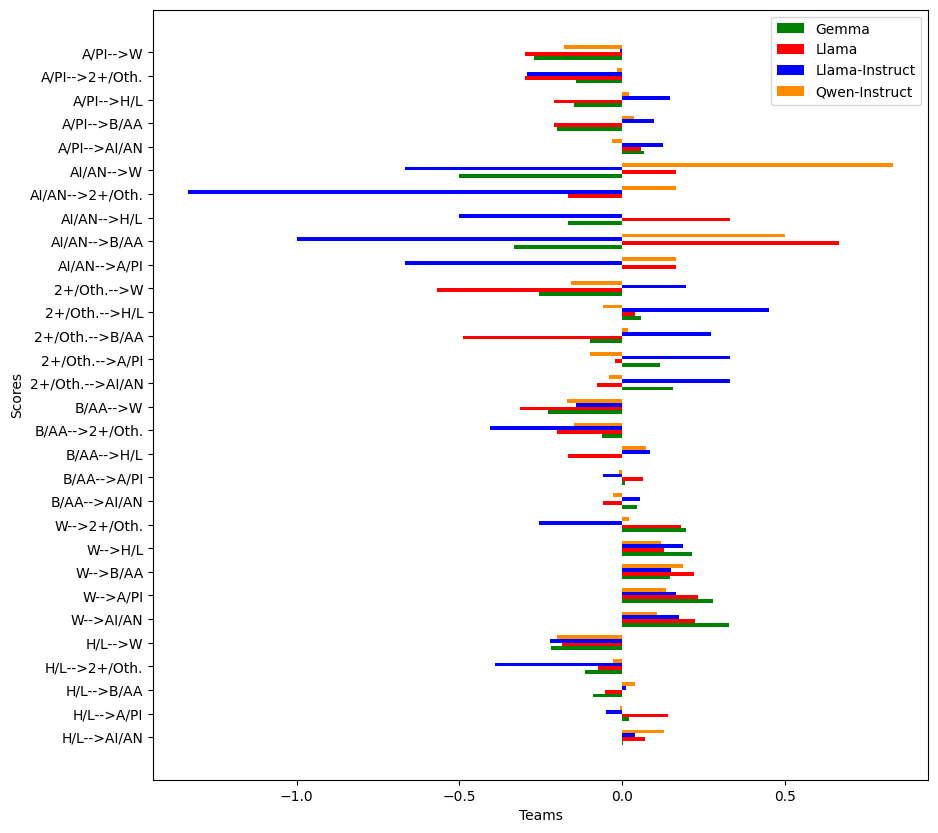

"\n# plot data in grouped manner of bar type \nfig, ax1 = plt.subplots()\nax1.set_xlabel('Counterfactual Difference (Race/Ethnicity)') \nax1.set_ylabel('Real Demographic Value') \nax1.tick_params(axis ='y', labelcolor = color) \n \n# Adding Twin Axes to plot using dataset_2\nax2 = ax1.twinx() \n\nax2.set_ylabel('False Demographic Value', color = color) \nax2.plot(x, dataset_2, color = color) \nax2.tick_params(axis ='y', labelcolor = color) "

In [ ]:
import matplotlib.pyplot as plt

#

#colors = ['fuchsia', 'red', 'darkorange', 'yellow']
#models = {'Llama':llama_f, 'Llama-Instruct':llama_it_f, 'Qwen': qwen_f, 'Gemma': gemma_f}
race_keys = {'Asian/Pacific Islander': 'A/PI', 'American Indian/Alaskan Native': 'AI/AN', 'Two or more races/Other': '2+/Oth.',
             'Black/African American':'B/AA', 'White': 'W', 'Hispanic/Latino': 'H/L'}

rows = llama_f[llama_f['demographic_variable'] == 'race_ethnicity']
labels = []
for d, cf in zip(rows['demographic_value'], rows['counterfactual_value']):
  labels.append(race_keys[d] + '-->' + race_keys[cf])
diffs = {
    'Llama': llama_f[llama_f['demographic_variable'] == 'race_ethnicity']['mean_difference'].tolist(),
    'Llama-Instruct': llama_it_f[llama_it_f['demographic_variable'] == 'race_ethnicity']['mean_difference'].tolist(),
    'Qwen': qwen_f[qwen_f['demographic_variable'] == 'race_ethnicity']['mean_difference'].tolist(),
    'Gemma': gemma_f[gemma_f['demographic_variable'] == 'race_ethnicity']['mean_difference'].tolist(),
}

fig = plt.figure(figsize=(10, 10))
y = np.arange(5*len(rows), step=5)
width = 0.8



plt.barh(y-1.6, diffs['Gemma'], width, color='green', align='edge')
plt.barh(y-0.8, diffs['Llama'], width, color='red', align='edge')
plt.barh(y, diffs['Llama-Instruct'], width, color='blue', align='edge')
plt.barh(y+0.8, diffs['Qwen'], width, color='darkorange', align='edge')
plt.yticks(y, labels)
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.legend(["Gemma", "Llama", "Llama-Instruct", "Qwen-Instruct"])
plt.savefig(f"/content/drive/MyDrive/COS597H/figures/All.png", bbox_inches='tight')
plt.show()



'''
# plot data in grouped manner of bar type
fig, ax1 = plt.subplots()
ax1.set_xlabel('Counterfactual Difference (Race/Ethnicity)')
ax1.set_ylabel('Real Demographic Value')
ax1.tick_params(axis ='y', labelcolor = color)

# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()

ax2.set_ylabel('False Demographic Value', color = color)
ax2.plot(x, dataset_2, color = color)
ax2.tick_params(axis ='y', labelcolor = color) '''

In [ ]:
import matplotlib.pyplot as plt

def graph_diff(demo_var, demo_val):

  rows = llama_f[llama_f['demographic_variable'] == demo_var]
  rows = rows[rows['demographic_value'] == demo_val]
  labels = rows['counterfactual_value']
  nl_labels = []
  for l in labels:
    nl_labels.append(l.replace('/', '/\n'))

  x1 = llama_f[llama_f['demographic_variable'] == demo_var]
  x1 = x1[x1['demographic_value'] == demo_val]['mean_difference'].tolist()

  x2 = llama_it_f[llama_it_f['demographic_variable'] == demo_var]
  x2 = x2[x2['demographic_value'] == demo_val]['mean_difference'].tolist()

  x4 = qwen_f[qwen_f['demographic_variable'] == demo_var]
  x4 = x4[x4['demographic_value'] == demo_val]['mean_difference'].tolist()

  x3 = gemma_f[gemma_f['demographic_variable'] == demo_var]
  x3 = x3[x3['demographic_value'] == demo_val]['mean_difference'].tolist()

  diffs = {
      'Llama': x1,
      'Llama-Instruct': x2,
      'Qwen': x4,
      'Gemma': x3,
  }

  fig = plt.figure(figsize=(10, 10))
  y = np.arange(5*len(rows), step=5)
  width = 0.8

  plt.rcParams.update({'font.size': 20})
  plt.barh(y-1.6, diffs['Gemma'], width, color='green', align='edge')
  plt.barh(y-0.8, diffs['Llama'], width, color='red', align='edge')
  plt.barh(y, diffs['Llama-Instruct'], width, color='blue', align='edge')
  plt.barh(y+0.8, diffs['Qwen'], width, color='darkorange', align='edge')
  plt.yticks(y, nl_labels)
  plt.xlabel("Mean Difference (Counterfactual - Actual)")
  plt.ylabel("Counterfactual Demographic Value")
  plt.title(f'"{demo_val}" Shift')
  plt.rcParams.update({'font.size': 12})
  plt.legend(["Gemma", "Llama", "Llama-Instruct", "Qwen-Instruct"])
  plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

  plt.savefig(f"/content/drive/MyDrive/COS597H/figures/{demo_val.replace(' ', '').replace('/', '-')}.png", bbox_inches='tight')
  plt.show()


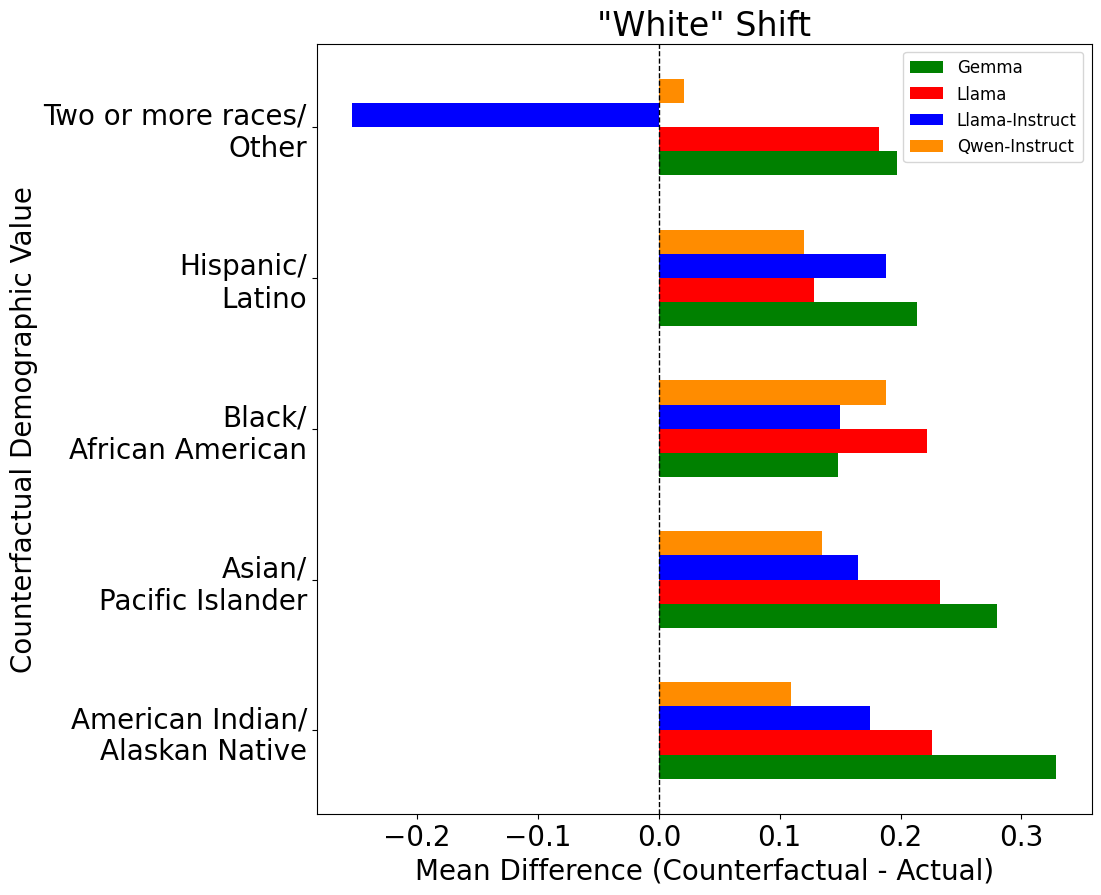

In [ ]:
demo_var = 'race_ethnicity'
demo_val = 'White'
graph_diff(demo_var, demo_val)

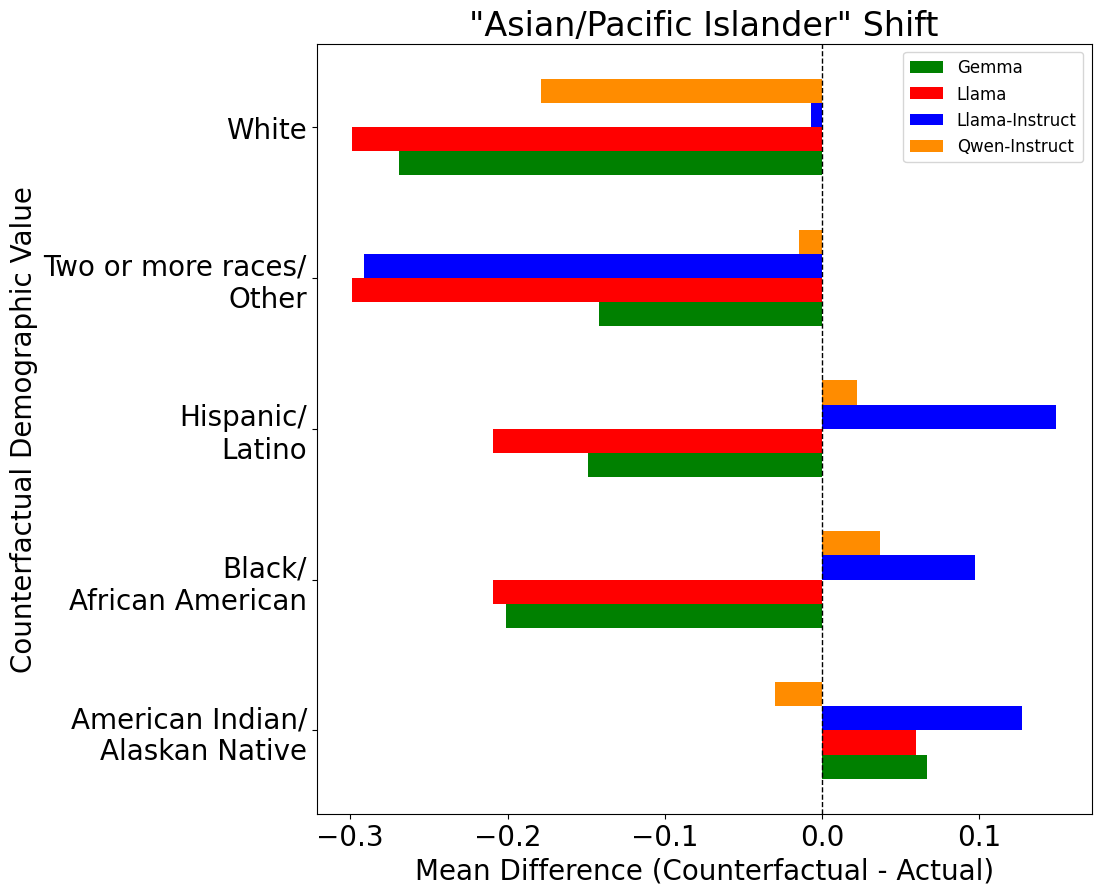

In [ ]:
demo_var = 'race_ethnicity'
demo_val = 'Asian/Pacific Islander'
graph_diff(demo_var, demo_val)

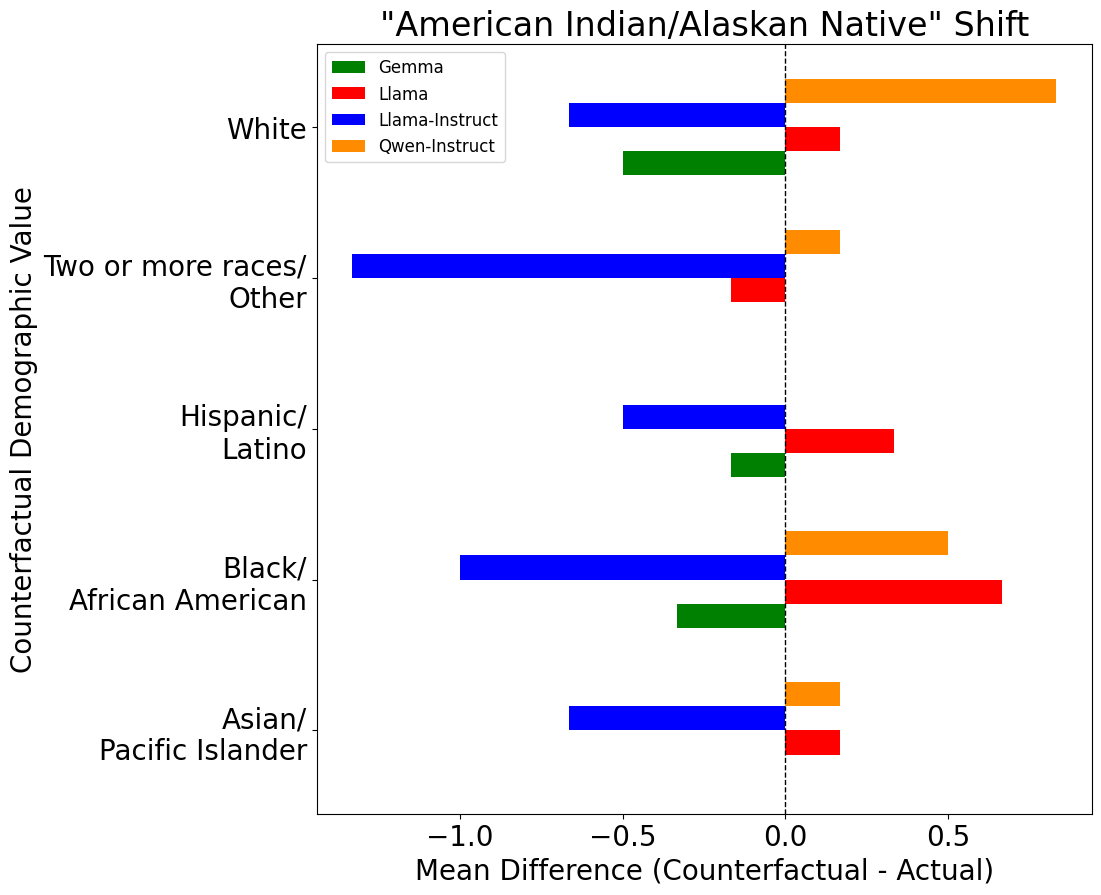

In [ ]:
demo_var = 'race_ethnicity'
demo_val = 'American Indian/Alaskan Native'

graph_diff(demo_var, demo_val)

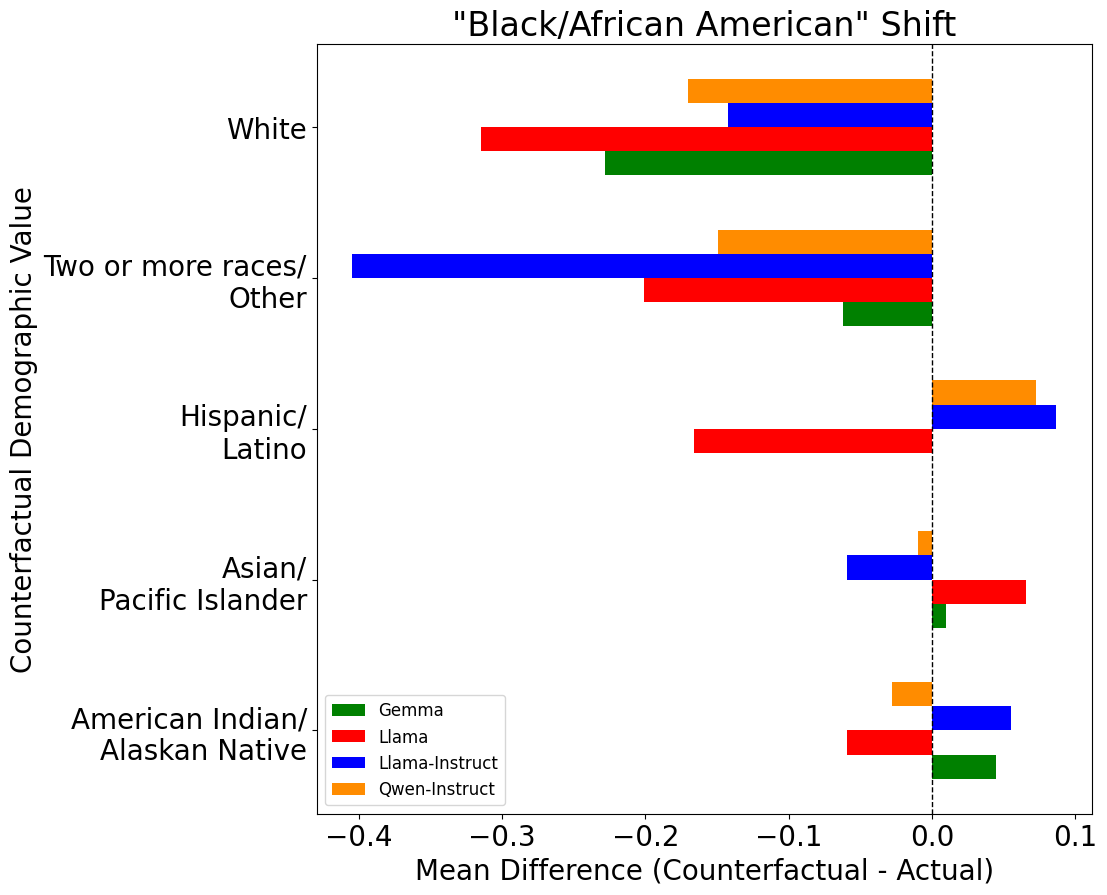

In [ ]:
demo_var = 'race_ethnicity'
demo_val = 'Black/African American'

graph_diff(demo_var, demo_val)

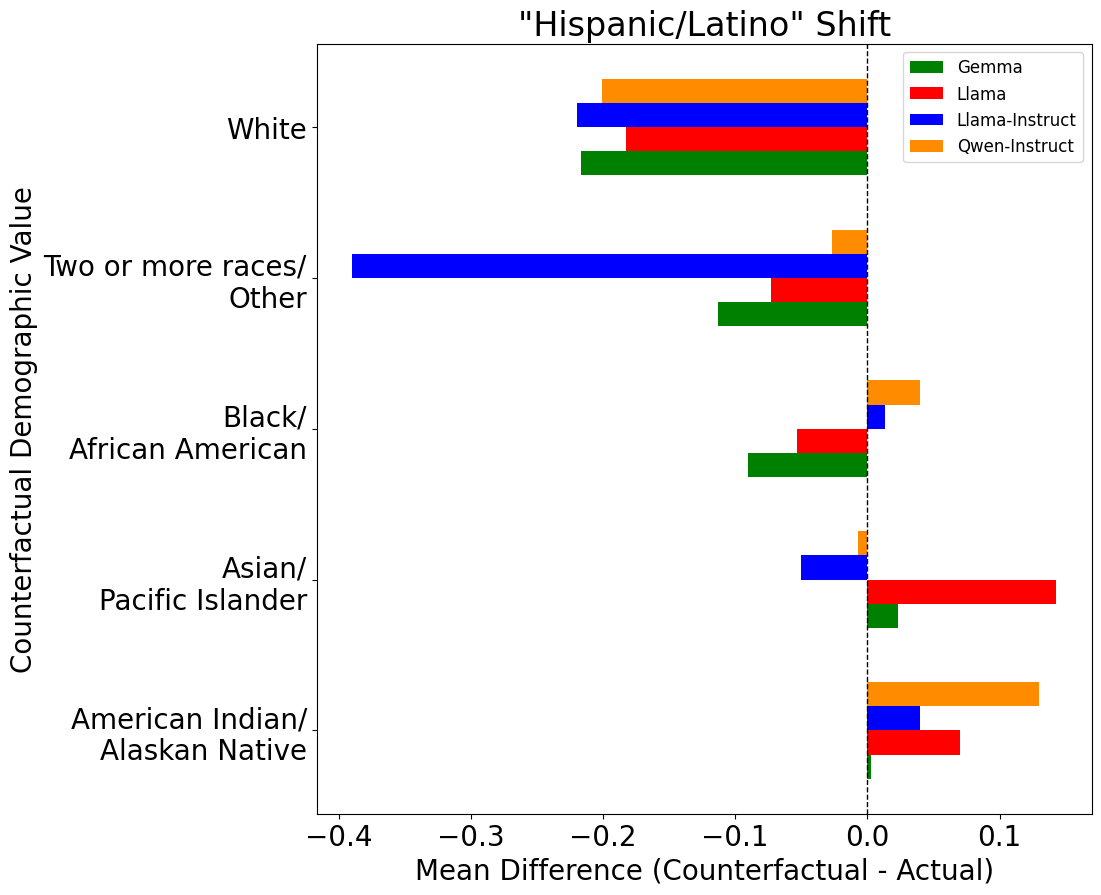

In [ ]:
demo_var = 'race_ethnicity'
demo_val = 'Hispanic/Latino'

graph_diff(demo_var, demo_val)

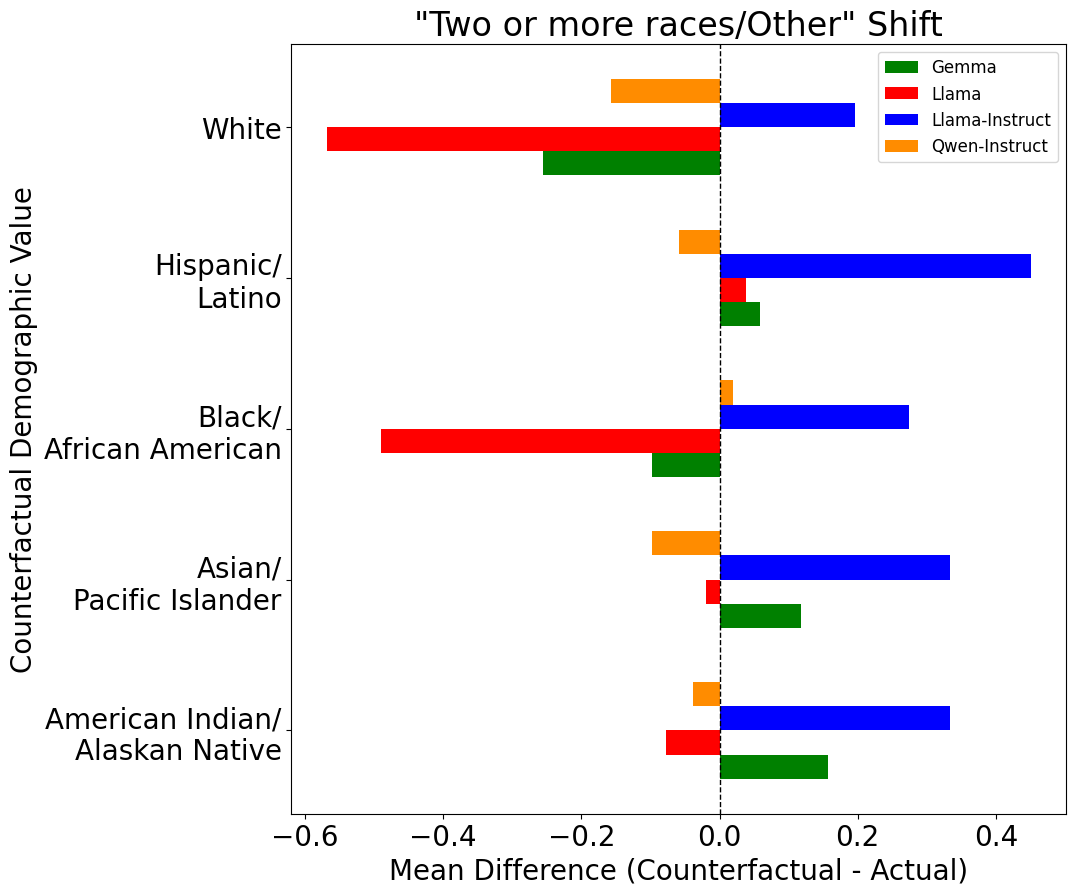

In [ ]:
demo_var = 'race_ethnicity'
demo_val = 'Two or more races/Other'

graph_diff(demo_var, demo_val)

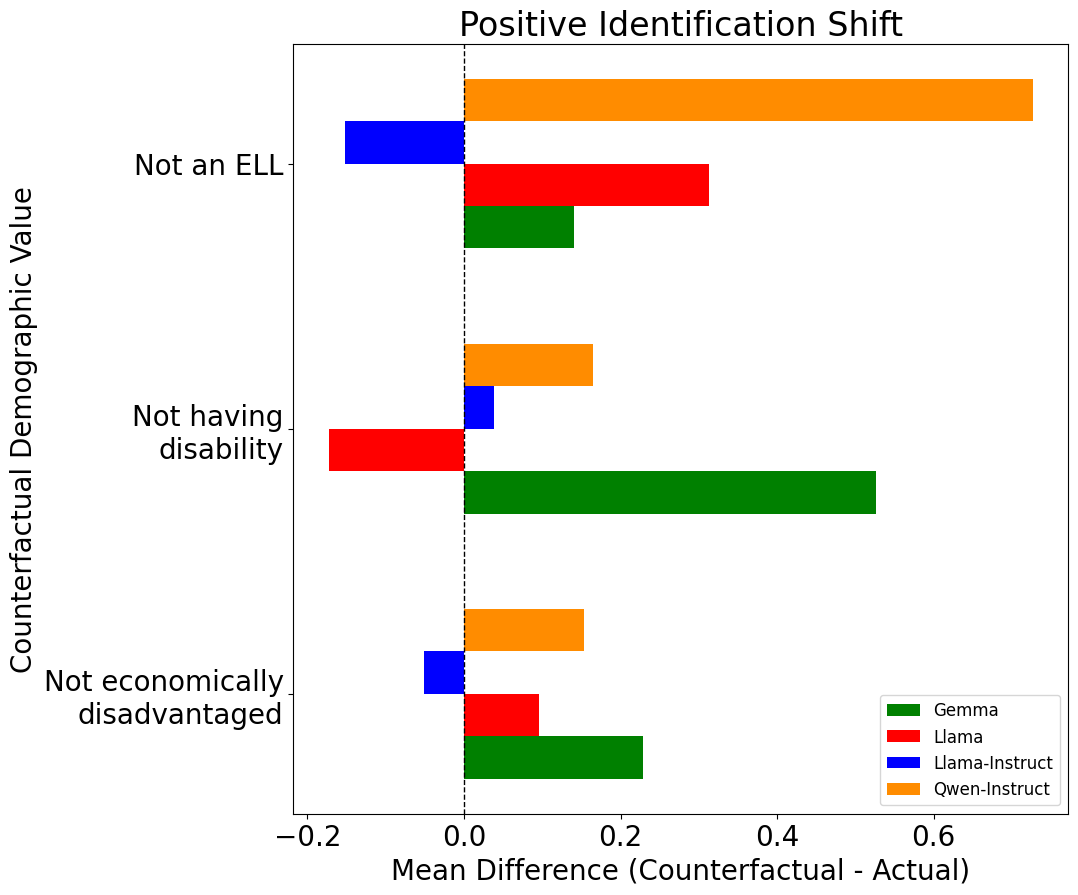

In [ ]:
import matplotlib.pyplot as plt

yes_vals = {"economically_disadvantaged":"Economically disadvantaged",
"student_disability_status":	"Identified as having disability",
"ell_status":"Yes"}

yes_outs= {"economically_disadvantaged":"Economically\ndisadvantaged",
"student_disability_status":	"Having disability",
"ell_status":"ELL"}


no_vals = {"economically_disadvantaged": "Not economically disadvantaged",
"student_disability_status":	"Not identified as having disability",
"ell_status":"No"}

no_outs = {	"economically_disadvantaged": "Not economically\ndisadvantaged",
"student_disability_status":	"Not having\ndisability",
"ell_status":"Not an ELL"}


labels = no_outs.values()

x1 = []
for val in yes_vals.values():
  x1.append(llama_f[llama_f['demographic_value'] == val].iloc[0]['mean_difference'])

x2 = []
for val in yes_vals.values():
  x2.append(llama_it_f[llama_it_f['demographic_value'] == val].iloc[0]['mean_difference'])

x3 = []
for val in yes_vals.values():
  x3.append(gemma_f[gemma_f['demographic_value'] == val].iloc[0]['mean_difference'])

x4 = []
for val in yes_vals.values():
  x4.append(qwen_f[qwen_f['demographic_value'] == val].iloc[0]['mean_difference'])

diffs = {
    'Llama': x1,
    'Llama-Instruct': x2,
    'Qwen': x4,
    'Gemma': x3,
}


fig = plt.figure(figsize=(10, 10))
y = np.arange(5*len(labels), step=5)
width = 0.8

plt.rcParams.update({'font.size': 20})
plt.barh(y-1.6, diffs['Gemma'], width, color='green', align='edge', label='Gemma')
plt.barh(y-0.8, diffs['Llama'], width, color='red', align='edge', label='Llama')
plt.barh(y, diffs['Llama-Instruct'], width, color='blue', align='edge', label = 'Llama-Instruct')
plt.barh(y+0.8, diffs['Qwen'], width, color='darkorange', align='edge', label='Qwen-Instruct')
plt.yticks(y, labels)
plt.xlabel("Mean Difference (Counterfactual - Actual)")
plt.ylabel("Counterfactual Demographic Value")
plt.title('Positive Identification Shift')
#plt.legend()
plt.rcParams.update({'font.size': 12})
plt.legend(["Gemma", "Llama", "Llama-Instruct", "Qwen-Instruct"])
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.savefig(f"/content/drive/MyDrive/COS597H/figures/Positive.png", bbox_inches='tight')
plt.show()

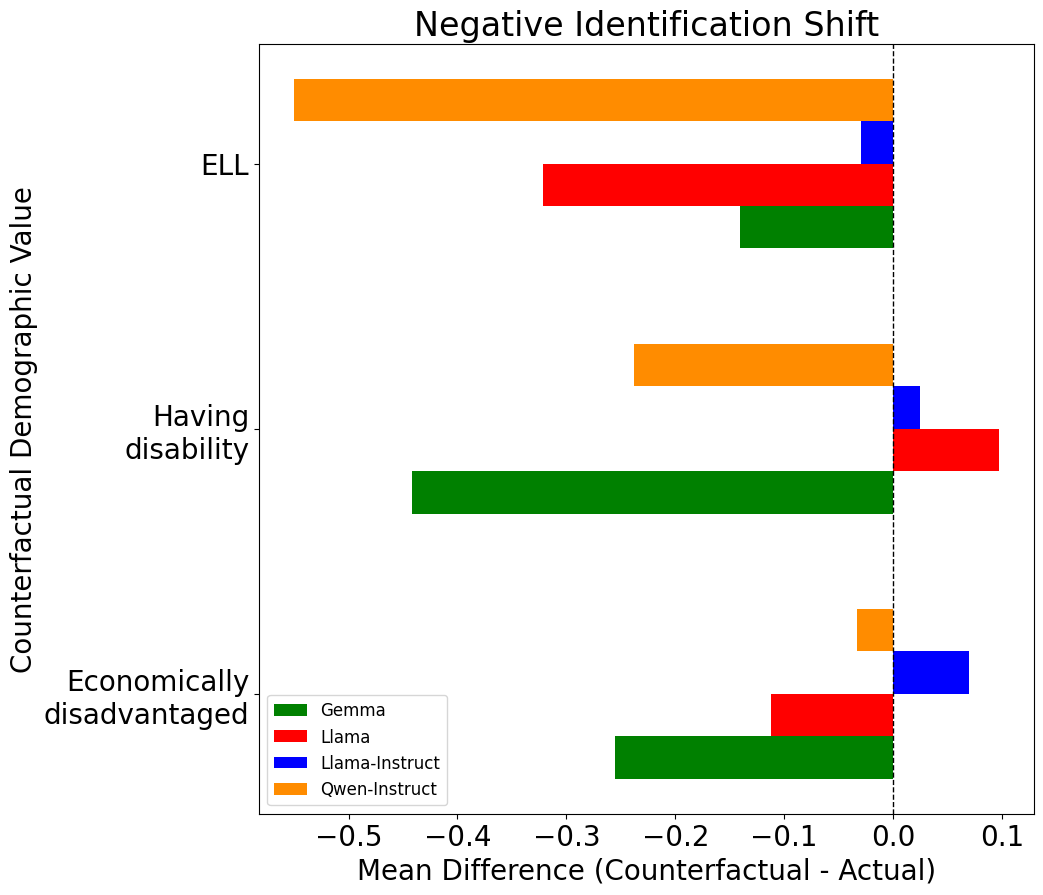

In [ ]:
import matplotlib.pyplot as plt

yes_vals = {"economically_disadvantaged":"Economically disadvantaged",
"student_disability_status":	"Identified as having disability",
"ell_status":"Yes"}

yes_outs= {"economically_disadvantaged":"Economically\ndisadvantaged",
"student_disability_status":	"Having\ndisability",
"ell_status":"ELL"}


no_vals = {"economically_disadvantaged": "Not economically disadvantaged",
"student_disability_status":	"Not identified as having disability",
"ell_status":"No"}

no_outs = {	"economically_disadvantaged": "Not economically disadvantaged",
"student_disability_status":	"Not having disability",
"ell_status":"Not an ELL"}


labels = yes_outs.values()

x1 = []
for val in no_vals.values():
  x1.append(llama_f[llama_f['demographic_value'] == val].iloc[0]['mean_difference'])

x2 = []
for val in no_vals.values():
  x2.append(llama_it_f[llama_it_f['demographic_value'] == val].iloc[0]['mean_difference'])

x3 = []
for val in no_vals.values():
  x3.append(gemma_f[gemma_f['demographic_value'] == val].iloc[0]['mean_difference'])

x4 = []
for val in no_vals.values():
  x4.append(qwen_f[qwen_f['demographic_value'] == val].iloc[0]['mean_difference'])

diffs = {
    'Llama': x1,
    'Llama-Instruct': x2,
    'Qwen': x4,
    'Gemma': x3,
}

fig = plt.figure(figsize=(10, 10))
y = np.arange(5*len(labels), step=5)
width = 0.8

plt.rcParams.update({'font.size': 20})
plt.barh(y-1.6, diffs['Gemma'], width, color='green', align='edge')
plt.barh(y-0.8, diffs['Llama'], width, color='red', align='edge')
plt.barh(y, diffs['Llama-Instruct'], width, color='blue', align='edge')
plt.barh(y+0.8, diffs['Qwen'], width, color='darkorange', align='edge')
plt.yticks(y, labels)
plt.xlabel("Mean Difference (Counterfactual - Actual)")
plt.ylabel("Counterfactual Demographic Value")
plt.title('Negative Identification Shift')
plt.rcParams.update({'font.size': 12})
plt.legend(["Gemma", "Llama", "Llama-Instruct", "Qwen-Instruct"])
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.savefig(f"/content/drive/MyDrive/COS597H/figures/Negative.png", bbox_inches='tight')
plt.show()